## import

In [1]:
import importlib
import sys
import time
import copy
from functools import partial

import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from scipy import ndimage
from skimage import io, transform

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import datasets, models, transforms
import tensorflow as tf

from sklearn.metrics import confusion_matrix
import h5py
import uproot
import pickle

cudnn.benchmark = True
plt.ion()


2023-07-02 13:38:51.524203: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-02 13:38:52.365268: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# functions

In [2]:
fields = [
    "Event/myChargeArray*",
]
def padTensorData(batch_data):

    max_dim = max(batch_data.size(1), batch_data.size(2))
    pad_width = max_dim - batch_data.size(2)
    pad_height = max_dim - batch_data.size(1)
    top_pad = pad_height // 2
    bottom_pad = pad_height - top_pad
    left_pad = pad_width // 2
    right_pad = pad_width - left_pad
    padded_tensor = F.pad(batch_data, (0,0,left_pad, right_pad, top_pad, bottom_pad), value=0)
    return padded_tensor


def generator2(files, label, batchSize):
    for array in uproot.iterate(files, step_size=batchSize,filter_name=fields,  library="ak"):
        features = array["myChargeArray[3][3][256][512]"].to_numpy()
        features = features.astype(float)
        features = np.sum(features, axis=2)
        features = np.moveaxis(features, 1, -1)
        
        # find max pixel in image, from merged image
        #merged_image = np.sum(features, axis=(3))

        # features/=np.amax(merged_image, keepdims=True)
        features /= np.amax(features, axis=(1,2,3), keepdims=True)

        tensor_data = torch.from_numpy(np.array(features))
        tensor_data = tensor_data.float()
        padded_tensor_data = padTensorData(tensor_data)
            

        labels = np.full((batchSize, ), label)
        yield padded_tensor_data , labels


def numberOfBatches(dataloader):
    number_of_batches=0
    for images, labels in dataloader:
        number_of_batches=number_of_batches+1
    return number_of_batches



# dataloaders

In [3]:
entries_per_batch = 100 # number of entries per batch
path = '/home/kris/Documents/coding/WAWTPC/krisTPCReco/TPCReco-kris/build/resources/'

In [4]:
class1Files = [path+'C12_ALPHA_1k_131MeV_250mbar_.root:TPCData']
datasetGenerator1 = partial(generator2, files=class1Files,label=2, batchSize=entries_per_batch)
dataloader1 = DataLoader(list(datasetGenerator1()))
arrayEvents_c1=[]
arrayLabels_c1=[]

In [5]:
for batch_images, batch_labels in dataloader1: # for each batch
    batch_images = batch_images.squeeze(0)
    batch_labels = batch_labels.squeeze(0)
    batch_images = batch_images.permute(0, 3, 1, 2)
    for event in range(entries_per_batch):              # for each event in batch [0->50]
        arrayEvents_c1.append(batch_images[event])      # first is always zero?
        arrayLabels_c1.append(batch_labels[event].item())
number_of_batches_1 = numberOfBatches(dataloader1)
del dataloader1

In [6]:
class2Files = [path+'THREE_ALPHA_BE+_1k_131MeV_250mbar_.root:TPCData']
datasetGenerator2 = partial(generator2, files=class2Files,label=3, batchSize=entries_per_batch)
dataloader2 = DataLoader(list(datasetGenerator2()))
arrayEvents_c2=[]
arrayLabels_c2=[]

In [9]:
for batch_images, batch_labels in dataloader2: # for each batch
    batch_images = batch_images.squeeze(0)
    batch_labels = batch_labels.squeeze(0)
    batch_images = batch_images.permute(0, 3, 1, 2)
    for event in range(entries_per_batch):              # for each event in batch [0->50]
        arrayEvents_c2.append(batch_images[event])      # first is always zero?
        arrayLabels_c2.append(batch_labels[event].item())
number_of_batches_2 = numberOfBatches(dataloader2)
del dataloader2

NameError: name 'dataloader2' is not defined

In [10]:
print('entries_per_batch ',entries_per_batch)
print('number_of_batches_1 ',number_of_batches_1)
print('number_of_batches_2 ',number_of_batches_2)

entries_per_batch  100
number_of_batches_1  10
number_of_batches_2  10


# inspect data

1000
3
512
512
label ===>  3


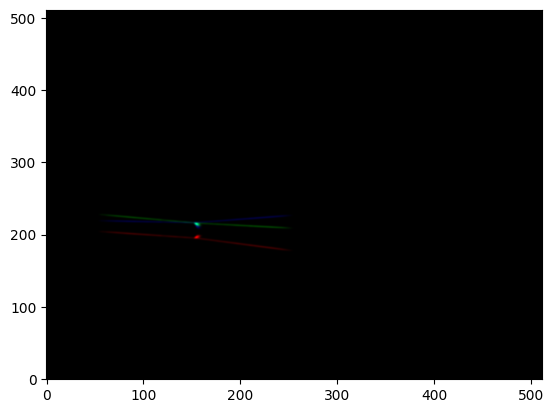

In [11]:
print(len(arrayEvents_c1))  #number of event
print(len(arrayEvents_c1[0])) #channel
print(len(arrayEvents_c1[0][0])) #X
print(len(arrayEvents_c1[0][0][0])) #Y

getEntry=1
data  = arrayEvents_c2[getEntry]
label = arrayLabels_c2[getEntry]

print('label ===> ',label)
fig, axis = plt.subplots()
data = data.numpy().transpose((1, 2, 0))
im = axis.imshow(data, origin='lower', aspect='auto')

# split datasets

In [12]:
from sklearn.model_selection import train_test_split
train_c1_images, test_c1_images, train_c1_labels, test_c1_labels = train_test_split(arrayEvents_c1, arrayLabels_c1, test_size=0.3)
del arrayEvents_c1
del arrayLabels_c1

train_c2_images, test_c2_images, train_c2_labels, test_c2_labels = train_test_split(arrayEvents_c2, arrayLabels_c2, test_size=0.3)
del arrayEvents_c2
del arrayLabels_c2

del datasetGenerator1
del datasetGenerator2

print('Train c1 set size:', len(train_c1_images))
print('Test c1 set size:', len(test_c1_images))
print('============================================')
print('Train c2 set size:', len(train_c2_images))
print('Test c2 set size:', len(test_c2_images))

# Concatenate class 1 images and labels
train_images = np.concatenate((train_c1_images, train_c2_images))
del train_c1_images
del train_c2_images
train_labels = np.concatenate((train_c1_labels, train_c2_labels))
del train_c1_labels
del train_c2_labels
test_images = np.concatenate((test_c1_images, test_c2_images))
del test_c1_images
del test_c2_images
test_labels = np.concatenate((test_c1_labels, test_c2_labels))
del test_c1_labels
del test_c2_labels

print('Train set size:', len(train_images))
print('Test set size:', len(test_images))


Train c1 set size: 700
Test c1 set size: 300
Train c2 set size: 700
Test c2 set size: 300
Train set size: 1400
Test set size: 600


<__array_function__ internals>:180: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## shuffle

In [13]:
import random
# Combine the images and labels into a single list
train_data = list(zip(train_images, train_labels))
test_data = list(zip(test_images, test_labels))

del train_images
del train_labels
del test_images
del test_labels

# Shuffle the data
random.shuffle(train_data)
random.shuffle(test_data)

# Unzip the shuffled data back into separate lists
shuffled_train_images, shuffled_train_labels = zip(*train_data)
shuffled_test_images, shuffled_test_labels = zip(*test_data)
del train_data
del test_data


print('Train set size:', len(shuffled_train_images))
print('Test set size:', len(shuffled_test_images))

print('Train set size:', len(shuffled_train_labels))
print('Test set size:', len(shuffled_test_labels))

Train set size: 1400
Test set size: 600
Train set size: 1400
Test set size: 600


# train

In [14]:
hdf5_file = h5py.File("shuffled_train_images_tensor.h5", "w")

shuffled_train_images_tensor = torch.stack(shuffled_train_images)
del shuffled_train_images
print(type(shuffled_train_images_tensor))
print(shuffled_train_images_tensor.shape)
hdf5_file.create_dataset("images", data=shuffled_train_images_tensor)
del shuffled_train_images_tensor


shuffled_train_labels_tensor = torch.tensor(shuffled_train_labels)
del shuffled_train_labels
print(type(shuffled_train_labels_tensor))
print(shuffled_train_labels_tensor.shape)
hdf5_file.create_dataset("labels", data=shuffled_train_labels_tensor)
del shuffled_train_labels_tensor

hdf5_file.close()
del hdf5_file

<class 'torch.Tensor'>
torch.Size([1400, 3, 512, 512])


# test

In [ ]:
hdf5_file = h5py.File("shuffled_test_images_tensor.h5", "w")

shuffled_test_images_tensor = torch.stack(shuffled_test_images)
del shuffled_test_images
print(type(shuffled_test_images_tensor))
print(shuffled_test_images_tensor.shape)
hdf5_file.create_dataset("images", data=shuffled_test_images_tensor)
del shuffled_test_images_tensor



shuffled_test_labels_tensor = torch.tensor(shuffled_test_labels)
print(type(shuffled_test_labels_tensor))
print(shuffled_test_labels_tensor.shape)
del shuffled_test_labels
del shuffled_test_labels_tensor

: 

: 

In [ ]:
shuffled_test_labels_tensor = torch.tensor(shuffled_test_labels)
print(type(shuffled_test_labels_tensor))
print(shuffled_test_labels_tensor.shape)
del shuffled_test_labels
del shuffled_test_labels_tensor

NameError: name 'shuffled_test_labels' is not defined

# make dataset 

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
train_ds = TensorDataset(shuffled_train_images_tensor, shuffled_train_labels_tensor)
train_dl = DataLoader(train_ds, batch_size=10, shuffle=True)

In [ ]:
valid_ds = TensorDataset(shuffled_test_images_tensor, shuffled_test_labels_tensor)
valid_dl = DataLoader(test_ds, batch_size=10, shuffle=True)

In [ ]:

dataloaders = {'train': train_dl, 'val': valid_dl}
dataset_sizes = {'train': len(train_ds), 'val': len(valid_ds)}


torch.Size([10, 3, 512, 512])
torch.Size([10])


In [ ]:
model_ft = models.resnet18(pretrained=True) # <------------------------------------------------------------
num_ftrs = model_ft.fc.in_features

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# initialise a fully connected layer with appropriate dimensions (num_ftrs x num_classes)
model_ft.fc = nn.Linear(num_ftrs, 4) # <------------------------------------------------------------
model_ft = model_ft.to(device)

# set the loss function
criterion = nn.CrossEntropyLoss()

# set the optimiser
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.90)

# decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

/home/kris/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kris/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):

    # start a timer
    since = time.time()

    # track the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # iterate over all epochs
    for epoch in range(num_epochs):

        # show the current epoch we are on
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # set model to training mode
            else:
                model.eval()   # set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward pass (track gradients if only in train mode)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in train mode
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # track the performance statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # step the learning rate scheduler if in train mode
            if phase == 'train':
                scheduler.step()

            # keep track of the overall loss and accuracy over each epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f}')

            # keep a deep copy of the best performing model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # track the time taken
    time_elapsed = time.time() - since
    print(f'training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'best val acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
#model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=15);


Epoch 0/14
----------


TypeError: '_TensorSliceDataset' object is not subscriptable

2023-07-01 00:51:11.204901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-07-01 00:51:11.300015: W tensorflow/core/framework/op_kernel.cc:1818] UNKNOWN: CannotBeAwkward: SimHit
Traceback (most recent call last):

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    ret = func(*args)

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/kris/Documents/coding/WAWTPC

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} CannotBeAwkward: SimHit
Traceback (most recent call last):

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    ret = func(*args)

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/kris/Documents/coding/WAWTPC/ML/MachineLearningTPC/MachineLearning/WAWTPC/classification/TPCParser.py", line 178, in generator
    for array in uproot.iterate(files, step_size=batchSize,

  File "/home/kris/.local/lib/python3.10/site-packages/uproot/behaviors/TBranch.py", line 193, in iterate
    for item in hasbranches.iterate(

  File "/home/kris/.local/lib/python3.10/site-packages/uproot/behaviors/TBranch.py", line 1080, in iterate
    _ranges_or_baskets_to_arrays(

  File "/home/kris/.local/lib/python3.10/site-packages/uproot/behaviors/TBranch.py", line 3041, in _ranges_or_baskets_to_arrays
    arrays[cache_key] = interpretation.final_array(

  File "/home/kris/.local/lib/python3.10/site-packages/uproot/interpretation/objects.py", line 423, in final_array
    output = library.finalize(

  File "/home/kris/.local/lib/python3.10/site-packages/uproot/interpretation/library.py", line 572, in finalize
    interpretation.awkward_form(interpretation.branch.file).to_json()

  File "/home/kris/.local/lib/python3.10/site-packages/uproot/interpretation/objects.py", line 113, in awkward_form
    return self._model.awkward_form(self._branch.file, context)

  File "/home/kris/.local/lib/python3.10/site-packages/uproot/containers.py", line 691, in awkward_form
    values_form = uproot._util.awkward_form(self._values, file, context)

  File "/home/kris/.local/lib/python3.10/site-packages/uproot/_util.py", line 587, in awkward_form
    return model.awkward_form(file, context)

  File "/home/kris/.local/lib/python3.10/site-packages/uproot/containers.py", line 1063, in awkward_form
    uproot._util.awkward_form(self._values, file, context),

  File "/home/kris/.local/lib/python3.10/site-packages/uproot/_util.py", line 587, in awkward_form
    return model.awkward_form(file, context)

  File "/home/kris/.local/lib/python3.10/site-packages/uproot/model.py", line 686, in awkward_form
    raise uproot.interpretation.objects.CannotBeAwkward(

uproot.interpretation.objects.CannotBeAwkward: SimHit


	 [[{{node PyFunc}}]] [Op:IteratorGetNext]

2023-07-01 00:05:06.796271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-07-01 00:05:15.910875: W tensorflow/core/framework/op_kernel.cc:1818] INVALID_ARGUMENT: TypeError: `generator` yielded an element of shape (100, 3, 3, 512, 3) where an element of shape (None, 512, 512, 3) was expected.
Traceback (most recent call last):

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    ret = func(*args)

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 235, in genera

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} TypeError: `generator` yielded an element of shape (100, 3, 3, 512, 3) where an element of shape (None, 512, 512, 3) was expected.
Traceback (most recent call last):

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    ret = func(*args)

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 235, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (100, 3, 3, 512, 3) where an element of shape (None, 512, 512, 3) was expected.


	 [[{{node PyFunc}}]] [Op:IteratorGetNext]

2023-07-01 00:05:17.557835: W tensorflow/core/framework/op_kernel.cc:1818] INVALID_ARGUMENT: TypeError: `generator` yielded an element of shape (100, 3, 3, 512, 3) where an element of shape (None, 512, 512, 3) was expected.
Traceback (most recent call last):

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    ret = func(*args)

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 235, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (100, 3, 3, 512, 3) where an element of shape (None, 512, 512, 3) was expected.


2023-07-01 00:05:17.557930: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start abort

## Training Dataset preparation

/home/kris/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kris/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
